In [1]:
import numpy as np
import re
import cmath
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import xml.etree.ElementTree as ET
import matplotlib.patches as mpatches

In [12]:
file = open("G-clef.svg")

regex = "d=.*?z"
path = re.search(regex,file.read()).group()
paths = path[3:].split(" ")

In [13]:
class Line:
    
    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.path_length = ((self.end.imag - self.start.imag)**2 + (self.end.real-self.start.real)**2)**1/2
        
        
    def set_size(self, size):
        self.size=size
        
    def x(self, t):
        return (self.end.real-self.start.real)*t/self.size +self.start.real
    
    def y(self, t):
        return (self.end.imag-self.start.imag)*t/self.size + self.start.imag
    
    def get_path_length(self):
        return self.path_length

In [14]:
class CBezier:
    N = np.linspace(0,1,1001)
    
    def __init__(self, start, end, c1, c2):
        self.start = start
        self.end = end
        self.c1 = c1
        self.c2 = c2
        self.size = 1
        self.path_length = 0
        
        for i in range(len(self.N)-1):
            l_start_x = self.x(self.N[i])
            l_start_y = self.y(self.N[i])
            l_end_x = self.x(self.N[i+1])
            l_end_y = self.y(self.N[i+1])
            
            l = Line(complex(l_start_x, l_start_y), complex(l_end_x,l_end_y))
            self.path_length+=l.get_path_length()
            
        
    def set_size(self, size):
        self.size=size
        
    def x(self, t):
        t = t/self.size
        return (1-t)**3*self.start.real + 3*(1-t)**2*t*self.c1.real +3*(1-t)*t**2*self.c2.real + t**3*self.end.real
    
    def y(self, t):
        t = t/self.size
        return (1-t)**3*self.start.imag + 3*(1-t)**2*t*self.c1.imag +3*(1-t)*t**2*self.c2.imag + t**3*self.end.imag
    
    def get_path_length(self):
        return ((self.c2.real-self.c1.real)**2 + (self.c2.imag - self.c1.imag)**2)**1/2

In [15]:
def get_complex_coords(string):
    c = [float(n) for n in string.split(",")]
    return complex(c[0], -c[1])

coords = complex(0,0)
i = 0
total_length = 0
instr = []
while i < len(paths):
    if paths[i] == "M":
        coords = get_complex_coords(paths[i+1])
        i+=2 
    elif paths[i] == "L":
        end = get_complex_coords(paths[i+1])
        line = Line(coords, end)
        instr.append(line)
        total_length += line.get_path_length()
        coords = end
        i+=2
    elif paths[i] == "C":
        end= get_complex_coords(paths[i+3])
        curve = CBezier(coords, end, get_complex_coords(paths[i+1]), get_complex_coords(paths[i+2]))
        instr.append(curve)
        total_length += curve.get_path_length()
        coords = end
        i+=4
    else:
        i+=1
        
starts = []
curr_length = 0

for i in instr:
    s=i.get_path_length()/total_length
    i.set_size(s)
    starts.append(curr_length)   
    curr_length += s

In [16]:
count = 0
t_space = np.linspace(0,1,10001)
x=[]
y=[]
for t in t_space:
    if count != len(starts)-1 and starts[count+1] < t:
        count += 1
    x.append(instr[count].x(t-starts[count]))
    y.append(instr[count].y(t-starts[count]))
    


In [17]:
count = 0
constant_count = 4
constants = {}
delta_t = t_space[1]-t_space[0]
for i in range(-constant_count, constant_count+1):
    constants[i] = 0
    for j in range(len(t_space)):
        constants[i]+=cmath.exp(complex(0,-2*cmath.pi*i*t_space[j]))*complex(x[j],y[j])*delta_t
        

In [18]:
fourier_values = []
for i in range(len(t_space)):
    fourier_values.append(complex(0,0))
    for j in range(-constant_count, constant_count+1):
        fourier_values[i] += constants[j]*cmath.exp(j*2*cmath.pi*complex(0,1)*t_space[i])

In [19]:
f_x = []
f_y = []
for c in fourier_values:
    f_x.append(c.real)
    f_y.append(c.imag)

In [20]:
def f_series(instr, starts, constant_count, color=(0,0,0)):
    count = 0
    t_space = np.linspace(0,1,10001)
    x=[]
    y=[]
    for t in t_space:
        if count != len(starts)-1 and starts[count+1] < t:
            count += 1
        x.append(instr[count].x(t-starts[count]))
        y.append(instr[count].y(t-starts[count]))
    count = 0
    constants = {}
    delta_t = t_space[1]-t_space[0]
    for i in range(-constant_count, constant_count+1):
        constants[i] = 0
        for j in range(len(t_space)):
            constants[i]+=cmath.exp(complex(0,-2*cmath.pi*i*t_space[j]))*complex(x[j],y[j])*delta_t

    fourier_values = []
    for i in range(len(t_space)):
        fourier_values.append(complex(0,0))
        for j in range(-constant_count, constant_count+1):
            fourier_values[i] += constants[j]*cmath.exp(j*2*cmath.pi*complex(0,1)*t_space[i])

    f_x = []
    f_y = []
    for c in fourier_values:
        f_x.append(c.real)
        f_y.append(c.imag)

    plt.plot(f_x, f_y, linewidth=2.0)


In [339]:
def f_series_anim(instr, starts, constant_count, color=(0,0,0)):
    frames = 100001
    count = 0
    t_space = np.linspace(0,1,10001)
    x=[]
    y=[]
    for t in t_space:
        if count != len(starts)-1 and starts[count+1] < t:
            count += 1
        x.append(instr[count].x(t-starts[count]))
        y.append(instr[count].y(t-starts[count]))
    count = 0
    constants = {}
    delta_t = t_space[1]-t_space[0]
    
    fig = plt.figure()
    ax = plt.axes(xlim=(0, 400), ylim=(0, -600))
    line, = ax.plot([],[])
    
    def init():
        line.set_data([],[])
        return line,
    
    
    for i in range(-constant_count, constant_count+1):
        constants[i] = 0
        for j in range(len(t_space)):
            constants[i]+=cmath.exp(complex(0,-2*cmath.pi*i*t_space[j]))*complex(x[j],y[j])*delta_t

    fourier_values = []
    f_x = []
    f_y = []
    def animate(i):
        fourier_values.append(complex(0,0))
        for j in range(-constant_count, constant_count+1):
            fourier_values[i-1] += constants[j]*cmath.exp(j*2*cmath.pi*complex(0,1)*t_space[i-1])
            f_x.append(fourier_values[i-1].real)
            f_y.append(fourier_values[i-1].imag)
        line.set_data(f_x,f_y)
        return line,

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=20, blit=True)
    
    anim.save('f_series.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    
    plt.show()
    


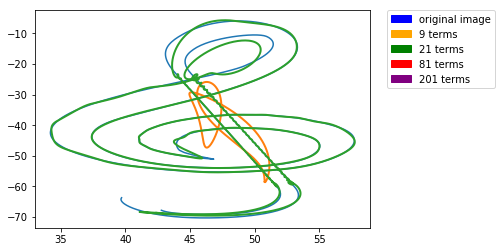

In [23]:
plt.plot(x, y)
f_series(instr, starts, 4)
#f_series(instr, starts, 10)
#f_series(instr, starts, 40)
f_series(instr, starts, 100)

orange_patch = mpatches.Patch(color='orange', label='9 terms')
green_patch = mpatches.Patch(color='green', label='21 terms')
red_patch = mpatches.Patch(color='red', label='81 terms')
purple_patch = mpatches.Patch(color='purple', label='201 terms')
blue_patch = mpatches.Patch(color='blue', label='original image')
plt.legend(handles=[blue_patch,orange_patch,green_patch,red_patch,purple_patch],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
